# Solving the Flexible Job-Shop Scheduling Problem (FJSP)

The following notebook explains the FJSP and explains the solution construction process using an encoder-decoder architecture based on a Heterogeneous Graph Neural Network (HetGNN)

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/other/2-scheduling.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time
import networkx as nx
import matplotlib.pyplot as plt
from rl4co.envs import FJSPEnv
from rl4co.models.zoo.l2d import L2DModel
from rl4co.models.zoo.l2d.policy import L2DPolicy
from rl4co.models.zoo.l2d.decoder import L2DDecoder
from rl4co.models.nn.graph.hgnn import HetGNNEncoder
from rl4co.utils.trainer import RL4COTrainer

/home/laurin.luttmann/miniconda3/envs/cuda1203/lib/python3.10/site-packages/lightning_utilities/core/imports.py:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/laurin.luttmann/miniconda3/envs/cuda1203/lib/python3.10/site-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/laurin.luttmann/miniconda3/envs/cuda1203/lib/python3.10/site-packages/pkg_resources/__init__.py:2317: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/l

In [3]:
generator_params = {
  "num_jobs": 5,  # the total number of jobs
  "num_machines": 5,  # the total number of machines that can process operations
  "min_ops_per_job": 1,  # minimum number of operatios per job
  "max_ops_per_job": 2,  # maximum number of operations per job
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 20,  # the maximum time required for a machine to process an operation
  "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
  "max_eligible_ma_per_op": 2,  # the maximum number of machines capable to process an operation
}

In [4]:
env = FJSPEnv(generator_params=generator_params)
td = env.reset(batch_size=[1])

## Visualize the Problem

Below we visualize the generated instance of the FJSP. Blue nodes correspond to machines, red nodes to operations and yellow nodes to jobs. A machine may process an operation if there exists an edge between the two. 

The thickness of the connection between a machine and an operation node specifies the processing time the respective machine needs to process the operation (thicker line := longer processing).

Each operation belongs to exactly one job, where an edge between a job and an operation node indicates that the respective operation belongs to the job. The number above an operation-job edge specifies the precedence-order in which the operations of a job need to be processed. A job is done when all operations belonging to it are scheduled. The instance is solved when all jobs are fully scheduled.

Also note that some operation nodes are not connected. These operation nodes are padded, so that all instances in a batch have the same number of operations (where we determine the maximum number of operations as num_jobs * max_ops_per_job). 

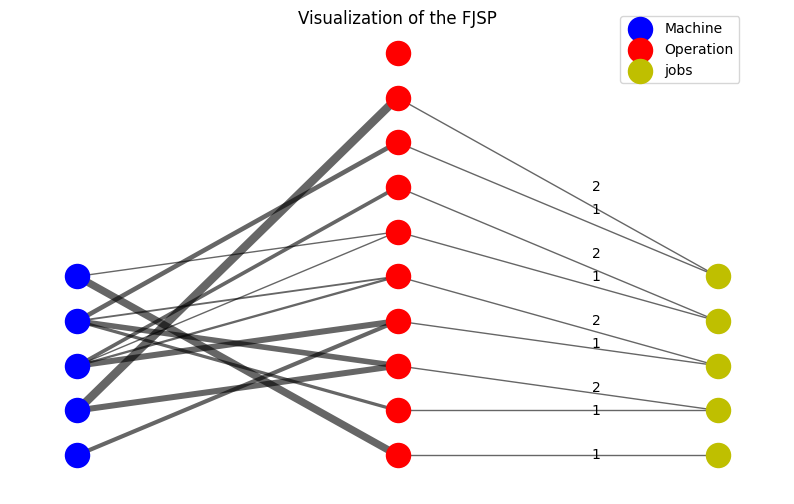

In [5]:
# Create a bipartite graph from the adjacency matrix
G = nx.Graph()
proc_times = td["proc_times"].squeeze(0)
job_ops_adj = td["job_ops_adj"].squeeze(0)
order = td["ops_sequence_order"].squeeze(0) + 1

num_machines, num_operations = proc_times.shape
num_jobs = job_ops_adj.size(0)

jobs = [f"j{i+1}" for i in range(num_jobs)]
machines = [f"m{i+1}" for i in range(num_machines)]
operations = [f"o{i+1}" for i in range(num_operations)]

# Add nodes from each set
G.add_nodes_from(machines, bipartite=0)
G.add_nodes_from(operations, bipartite=1)
G.add_nodes_from(jobs, bipartite=2)

# Add edges based on the adjacency matrix
for i in range(num_machines):
    for j in range(num_operations):
        edge_weigth = proc_times[i][j]
        if edge_weigth != 0:
            G.add_edge(f"m{i+1}", f"o{j+1}", weight=edge_weigth)


# Add edges based on the adjacency matrix
for i in range(num_jobs):
    for j in range(num_operations):
        edge_weigth = job_ops_adj[i][j]
        if edge_weigth != 0:
            G.add_edge(f"j{i+1}", f"o{j+1}", weight=3, label=order[j])


widths = [x / 3 for x in nx.get_edge_attributes(G, 'weight').values()]

plt.figure(figsize=(10,6))
# Plot the graph

machines = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
operations = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]
jobs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 2]

pos = {}
pos.update((node, (1, index)) for index, node in enumerate(machines))
pos.update((node, (2, index)) for index, node in enumerate(operations))
pos.update((node, (3, index)) for index, node in enumerate(jobs))

edge_labels = {(u, v): d['label'].item() for u, v, d in G.edges(data=True) if d.get("label") is not None}
nx.draw_networkx_edge_labels(G, {k: (v[0]+.12, v[1]) for k,v in pos.items()}, edge_labels=edge_labels, rotate=False)

nx.draw_networkx_nodes(G, pos, nodelist=machines, node_color='b', label="Machine")
nx.draw_networkx_nodes(G, pos, nodelist=operations, node_color='r', label="Operation")
nx.draw_networkx_nodes(G, pos, nodelist=jobs, node_color='y', label="jobs")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6)

plt.title('Visualization of the FJSP')
plt.legend(bbox_to_anchor=(.95, 1.05))
plt.axis('off')
plt.show()

## Build a Model to Solve the FJSP

In the FJSP we typically encode Operations and Machines separately, since they pose different node types in a k-partite Graph. Therefore, the encoder for the FJSP returns two hidden representations, the first containing machine embeddings and the second containing operation embeddings:

In [6]:
# Lets generate a more complex instance

generator_params = {
  "num_jobs": 10,  # the total number of jobs
  "num_machines": 5,  # the total number of machines that can process operations
  "min_ops_per_job": 4,  # minimum number of operatios per job
  "max_ops_per_job": 6,  # maximum number of operations per job
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 20,  # the maximum time required for a machine to process an operation
  "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
  "max_eligible_ma_per_op": 5,  # the maximum number of machines capable to process an operation
}

env = FJSPEnv(generator_params=generator_params)
td = env.reset(batch_size=[1])

In [7]:
encoder = HetGNNEncoder(embed_dim=32, num_layers=2)
(ma_emb, op_emb), init = encoder(td)
print(ma_emb.shape)
print(op_emb.shape)

torch.Size([1, 60, 32])
torch.Size([1, 5, 32])


The decoder return logits over a composite action-space of size (1 + num_jobs * num_machines), where each entry corresponds to a machine-job combination plus one **waiting**-operation. The selected action specifies, which job is processed next by which machine. To be more precise, the next operation of the selected job is processed. This operation can be retrieved from __td["next_op"]__

In [8]:
# next operation per job
td["next_op"]

tensor([[ 0,  4,  9, 15, 21, 27, 31, 37, 41, 45]])

In [9]:
decoder = L2DDecoder(env_name=env.name, embed_dim=32)
logits, mask = decoder(td, (ma_emb, op_emb), num_starts=0)
# (1 + num_jobs * num_machines)
print(logits.shape)

torch.Size([1, 51])


In [10]:
def make_step(td):
    logits, mask = decoder(td, (ma_emb, op_emb), num_starts=0)
    action = logits.masked_fill(~mask, -torch.inf).argmax(1)
    td["action"] = action
    td = env.step(td)["next"]
    return td

## Visualize solution construction

Starting at $t=0$, the decoder uses the machine-operation embeddings of the encoder to decide which machine-**job**-combination to schedule next. Note, that due to the precedence relationship, the operations to be scheduled next are fixed per job. Therefore, it is sufficient to determine the next job to be scheduled, which significantly reduces the action space. 

After some operations have been scheduled, either all the machines are busy or all the jobs have been scheduled with their currently active operation. In this case, the environment transitions to a new time step $t$. The new $t$ will be equal to the first time step where a machine finishes an operation in the partial schedule. When an operation is finished, the machine that has processed it is immediately ready to process the next operation. Also, the next operation of the respective job can then be scheduled.

The start time of an operation is always equal to the time step in which it is scheduled. The finish time of an operation is equal to its start time plus the processing time required by the machine on which it is being processed.

The figure below visualises this process. 

<Figure size 640x480 with 0 Axes>

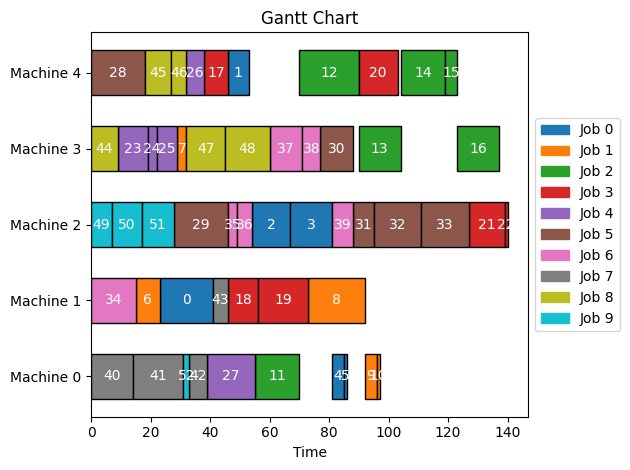

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
env.render(td, 0)
# Update plot within a for loop
while not td["done"].all():
    # Clear the previous output for the next iteration
    clear_output(wait=True)

    td = make_step(td)
    env.render(td, 0)
    # Display updated plot
    display(plt.gcf())
    
    # Pause for a moment to see the changes
    time.sleep(.4)

In [20]:
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 32
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

In [21]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy(embed_dim=embed_dim, num_encoder_layers=num_encoder_layers, env_name="fjsp")

# Model: default is AM with REINFORCE and greedy rollout baseline
model = L2DModel(env,
                 policy=policy, 
                 baseline="rollout",
                 batch_size=batch_size,
                 train_data_size=train_data_size,
                 val_data_size=1_000,
                 optimizer_kwargs={"lr": 1e-4})

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator=accelerator,
    devices=1,
    logger=None,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead


IndexError: The shape of the mask [256, 11] at index 1 does not match the shape of the indexed tensor [256, 101] at index 1

# Solving the Job-Shop Scheduling Problem (JSSP)

In [2]:
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader

In [3]:
# Lets generate a more complex instance

generator_params = {
  "num_jobs": 15,  # the total number of jobs
  "num_machines": 15,  # the total number of machines that can process operations
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 99,  # the maximum time required for a machine to process an operation
}

env = JSSPEnv(
    generator_params=generator_params, 
    _torchrl_mode=True, 
    stepwise_reward=True
)

## Train on synthetic data and test on Taillard benchmark

In [36]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim, 
    num_encoder_layers=num_encoder_layers, 
    env_name="jssp",
    het_emb=False
)

model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=batch_size,
    train_data_size=train_data_size,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4}
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Overriding gradient_clip_val to None for 'automatic_optimization=False' models
val_file not set. Generating dataset instead
Provided file name data/../../data/jssp/taillard/15j_15m not found. Make sure to provide a file in the right path first or unset test_file to generate data automatically instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]

  | Name       | Type          | Params
---------------------------------------------
0 | env        | JSSPEnv       | 0     
1 | policy     | L2DPolicy4PPO | 133 K 
2 | policy_old | L2DPolicy4PPO | 133 K 
---------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Epoch 0: 100%|█| 8/8 [03:40<00:00,  0.04it/s, v_num=9, train/loss=1.45e+3, train
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 4/4 [00:18<00:00,  0.22it/s]
Epoch 0: 100%|█| 8/8 [03:58<00:00,  0.03it/s, v_num=9, train/loss=1.45e+3, train

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 8/8 [03:58<00:00,  0.03it/s, v_num=9, train/loss=1.45e+3, train


In [ ]:
CHECKPOINT_PATH = "last.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    model = L2DPPOModel.load_from_checkpoint(CHECKPOINT_PATH)
except FileNotFoundError:

    trainer = RL4COTrainer(
        max_epochs=1,
        accelerator=accelerator,
        devices=1,
        logger=None,
    )

    trainer.fit(model)
finally:
    model = model.to(device)

In [8]:
# path to taillard instances
DATA_PATH = "../../ai4co/rl4co/data/jssp/taillard/{instance_type}"

results = {}
instance_types = ["15j_15m", "20j_15m", "20j_20m", "30j_15m", "30j_20m"]

for instance_type in instance_types:
    
    dataset = env.dataset(batch_size=[10], phase="test", filename=DATA_PATH.format(instance_type=instance_type))
    dl = DataLoader(dataset, batch_size=5, collate_fn=dataset.collate_fn)
    rewards = []
    
    for batch in dl:
        td = env.reset(batch).to(device)
        # use policy.generate to avoid grad calculations which can lead to oom 
        out = model.policy.generate(td, env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
        rewards.append(out["reward"])

    reward = torch.cat(rewards, dim=0).mean().item()
    results[instance_type] = reward

    print("Done evaluating instance type %s with reward %s" % (instance_type, reward))

    # avoid ooms due to cache not being cleared 
    model.rb.empty()
    gc.collect()
    torch.cuda.empty_cache()

Done evaluating instance type 30j_20m with reward -2357.900146484375
